In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pre-Processing

In [ ]:
BASE_PATH = "drive/MyDrive/Courses/DeepLearning/Project/"
std_scaler = StandardScaler()

def change_label(df):
  df.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  df.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  df.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  df.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

def normalization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

def get_processed_data(file_path):
    col_names = ["duration", "protocol_type", "service", "flag", "src_bytes",
                 "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
                 "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
                 "num_file_creations", "num_shells", "num_access_files", "num_outbound_cmds",
                 "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate",
                 "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate",
                 "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
                 "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
                 "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                 "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label", "difficulty_level"]

    # Read the data
    data = pd.read_csv(file_path, header=None, names=col_names)

    # Remove 'difficulty_level'
    data.drop(['difficulty_level'], axis=1, inplace=True)

    # Change labels
    change_label(data)

    # Normalize numerical features
    numeric_col = data.select_dtypes(include='number').columns

    data = normalization(data.copy(), numeric_col)

    # One-hot encode categorical attributes
    cat_col = ['protocol_type', 'service', 'flag']
    categorical = data[cat_col]
    categorical = pd.get_dummies(categorical, columns=cat_col)

    # Create binary labels
    bin_label = pd.DataFrame(data.label.map(lambda x: 'normal' if x == 'normal' else 'abnormal'))
    bin_data = data.copy()
    bin_data['label'] = bin_label

    # Label encoding for binary labels
    le1 = preprocessing.LabelEncoder()
    enc_label = bin_label.apply(le1.fit_transform)
    bin_data['intrusion'] = enc_label

    # Save label encoder classes to a file
    np.save("le1_classes.npy", le1.classes_, allow_pickle=True)

    # One-hot encode attack label
    bin_data = pd.get_dummies(bin_data, columns=['label'], prefix="", prefix_sep="")
    bin_data['label'] = bin_label

    # Select attributes based on correlation
    numeric_bin = bin_data[['count', 'srv_serror_rate', 'serror_rate', 'dst_host_serror_rate',
                            'dst_host_srv_serror_rate', 'logged_in', 'dst_host_same_srv_rate',
                            'dst_host_srv_count', 'same_srv_rate']]

    # Join selected attributes with one-hot-encoded categorical dataframe
    numeric_bin = numeric_bin.join(categorical)

    # Join encoded, one-hot-encoded, and original attack label attribute
    bin_data = numeric_bin.join(bin_data[['intrusion', 'abnormal', 'normal', 'label']])

    return bin_data

data_path = f'{BASE_PATH}NSL-KDD/KDDTrain+.txt'
processed_data = get_processed_data(data_path)
processed_data.to_csv(f"{BASE_PATH}bin_data.csv", index=False)

# Training Phase of Our Proposed Method with Transfer Learning

For a specified number of training iterations:

    Set the discriminator as trainable.
    
    Sample z from p(Z).
    
    Sample x from p(X) where y = Normal (Filter data where the label is "Normal").
    
    Compute f(z) = G(z) where f(z) ∈ X.
    
    Compute ˆf(x) = E(x) where ˆf(x) ∈ Z.
    
    Concatenate [f(z), z] with [x, ˆf(x)].
    
    Update D([f(z), z]) to maximize L(D([f(z), z])) and D([x, ˆf(x)]) to maximize L(D([x, ˆf(x)])) using Equation (2).
    
    Set the discriminator as non-trainable.
    
    For k steps:
    
        Sample z from p(Z).
        
        Sample x from p(X) where y = Normal (Filter data where the label is "Normal").
        
        Compute f(z) = G(z).
        
        Compute ˆf(x) = E(x).
        
        Concatenate [f(z), z] with [x, ˆf(x)].
        
        Update O(y|ˆy) using D([f(z), z]).
        
        Update G(f(z)) to minimize L(-log(D(f(z), z))).
        
        Update O(y|ˆy) using D([x, ˆf(x)]).
        
        Update E(ˆf(x)) to minimize L(-log(D(x, ˆf(x)))).
    
    End For
    
End For

Utilize pre-trained encoder and discriminator with initial layers of the discriminator set as non-trainable.

Ftransfer(x) = Fpre-trained(x) ⊕ TrainableLayers(x).

For each sample in the entire dataset:

    Train the model on the sample (previously trained exclusively on "Normal" data).
    
End For


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.functional import sigmoid, softmax
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary

instance_shape = 93
latent_dim = 10
# Move models to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Build the encoder model
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim),
            nn.ReLU()
        )
        # self.model.apply(initializer)

    def forward(self, x):
        return self.model(x)

# Build the generator model
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Build the discriminator model
class Discriminator(nn.Module):
    def __init__(self, latent_dim, input_dim, output_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Linear(latent_dim + input_dim, 64)
        self.mid1 = nn.Linear(64, 32)
        self.mid2 = nn.Linear(32, 16)
        self.out = nn.Linear(16, output_dim)

    def forward(self, z, img):
        d_in = torch.cat((z, img), dim=1)
        model = nn.LeakyReLU(0.2)(self.fc(d_in))
        model = nn.LeakyReLU(0.2)(self.mid1(model))
        model = nn.LeakyReLU(0.2)(self.mid2(model))
        validity = torch.sigmoid(self.out(model))
        return validity


In [ ]:
encoder_normal = Encoder(instance_shape, latent_dim)
encoder_normal = encoder_normal.to(device)
print(encoder_normal)

generator_normal = Generator(latent_dim, instance_shape)
generator_normal = generator_normal.to(device)
print(generator_normal)

discriminator = Discriminator(latent_dim, instance_shape, 1)
discriminator = discriminator.to(device)
print(discriminator)
print(sum(p.numel() for p in discriminator.parameters()))

Encoder(
  (model): Sequential(
    (0): Linear(in_features=93, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=10, bias=True)
    (3): ReLU()
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=93, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (fc): Linear(in_features=103, out_features=64, bias=True)
  (mid1): Linear(in_features=64, out_features=32, bias=True)
  (mid2): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)
9281


In [ ]:
# Define loss functions and optimizers
adv_loss = nn.BCELoss()  # Binary cross-entropy loss for adversarial training

optimizer_enc = optim.Adam(encoder_normal.parameters(), lr=0.002)
optimizer_gen = optim.Adam(generator_normal.parameters(), lr=0.002)
optimizer_disc = optim.Adam(discriminator.parameters(), lr=0.002)

# Training loop
num_epochs = 1000  # Adjust as needed
batch_size = 64  # Adjust as needed

valid = torch.zeros(batch_size, 1).to(device)
fake = torch.ones(batch_size, 1).to(device)
sample_interval = 10

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import time

bin_data_normal = processed_data[processed_data.normal==1]
X = bin_data_normal.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = bin_data_normal[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# n_noise = 64


train_losses = []
train_accs = []
val_losses = []
val_accs = []
gen_loss = []
disc_loss = []
enc_loss = []
disc_acc = []
for epoch in range(num_epochs):
  # Set the models to train mode
    encoder_normal.train()
    generator_normal.train()

    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    train_iter = iter(train_loader)
    real_data, labels = next(train_iter)
    optimizer_disc.zero_grad()
    discriminator.train()
    real_data, labels = real_data.to(device), labels.to(device)

    # Discriminator

    # Fake
    noise = torch.randn(batch_size, latent_dim).to(device)
    fake_data = generator_normal(noise)
    disc_outputs_fake = discriminator(fake_data, noise)
    loss_disc_fake = adv_loss(disc_outputs_fake, torch.zeros_like(disc_outputs_fake))
    loss_disc_fake.backward()
    disc_acc_fake = (disc_outputs_fake < 0.5).float().mean().item() * 100
    # Real
    real_latent = encoder_normal(real_data)
    disc_outputs_real = discriminator(real_data, real_latent)
    loss_disc_real = adv_loss(disc_outputs_real, torch.ones_like(disc_outputs_real))
    loss_disc_real.backward()
    disc_acc_real = (disc_outputs_real >= 0.5).float().mean().item() * 100


    # Average the two losses
    loss_disc = 0.5*(loss_disc_real + loss_disc_fake)
    acc_disc = 0.5 * (disc_acc_fake + disc_acc_real)
    # loss_disc.backward()
    optimizer_disc.step()
    discriminator.trainable = False
    optimizer_enc.zero_grad()
    optimizer_gen.zero_grad()
    k = 5
    for _ in range(k):
      optimizer_enc.step()
      optimizer_gen.step()

      # Train Generator
      real_latent = encoder_normal(real_data)
      noise = torch.randn(batch_size, latent_dim).to(device)
      fake_data = generator_normal(noise)

      disc_outputs_fake = discriminator(fake_data, noise)
      loss_gen = adv_loss(disc_outputs_fake, torch.ones_like(disc_outputs_fake))

      disc_outputs_real = discriminator(real_data, real_latent)
      loss_enc = adv_loss(disc_outputs_real, torch.zeros_like(disc_outputs_real))

      # loss_gen = -loss_gen
      # loss_enc = -loss_enc
      # loss_enc_gen = loss_gen + loss_enc
      loss_gen.backward()
      loss_enc.backward()
      # loss_enc_gen.backward()
      optimizer_enc.step()
      optimizer_gen.step()
    gen_loss.append(loss_gen.cpu())
    disc_loss.append(loss_disc.cpu())
    enc_loss.append(loss_enc.cpu())
    disc_acc.append(acc_disc)
    print(f"Epoch {epoch}/{num_epochs} Discriminator Loss {loss_disc} Discriminator Accuracy {acc_disc}, Generator Loss {loss_gen}, Encoder Loss {loss_enc}")

Epoch 0/1000 Discriminator Loss 0.6886427402496338 Discriminator Accuracy 49.21875, Generator Loss 0.7313430905342102, Encoder Loss 0.6848987340927124
Epoch 1/1000 Discriminator Loss 0.6791273355484009 Discriminator Accuracy 50.0, Generator Loss 0.7370750308036804, Encoder Loss 0.6926724314689636
Epoch 2/1000 Discriminator Loss 0.6729035377502441 Discriminator Accuracy 79.6875, Generator Loss 0.7375268340110779, Encoder Loss 0.7013733983039856
Epoch 3/1000 Discriminator Loss 0.6699294447898865 Discriminator Accuracy 98.4375, Generator Loss 0.7270887494087219, Encoder Loss 0.7116097211837769
Epoch 4/1000 Discriminator Loss 0.667715847492218 Discriminator Accuracy 99.21875, Generator Loss 0.7163910269737244, Encoder Loss 0.7236011028289795
Epoch 5/1000 Discriminator Loss 0.6678471565246582 Discriminator Accuracy 97.65625, Generator Loss 0.711453914642334, Encoder Loss 0.7341190576553345
Epoch 6/1000 Discriminator Loss 0.6675779819488525 Discriminator Accuracy 91.40625, Generator Loss 0.7

In [ ]:
# D_losses

,D_losses,G_losses,E_losses
0,0.68864274,0.7313431,0.68489873
1,0.67912734,0.73707503,0.69267243
2,0.67290354,0.73752683,0.7013734
3,0.66992944,0.72708875,0.7116097
4,0.66771585,0.716391,0.7236011
...,...,...,...
995,0.003795935,5.982469,12.330563
996,0.035527892,5.9504952,12.749004
997,0.024407279,5.8280864,12.219997
998,0.04779137,5.74498,11.5861


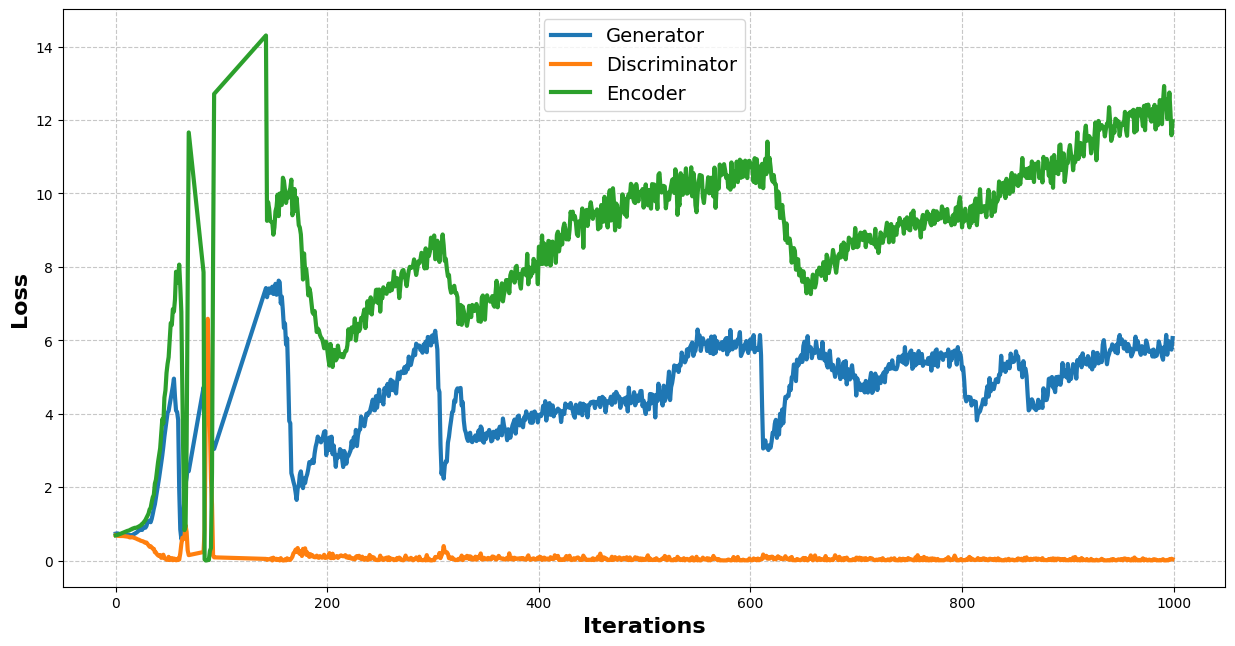

In [ ]:
%matplotlib inline
D_losses = [i.detach().numpy() for i in disc_loss]
G_losses = [i.detach().numpy() for i in gen_loss]
E_losses = [i.detach().numpy() for i in enc_loss]
data = pd.DataFrame({"D_losses": D_losses,"G_losses": G_losses,"E_losses": E_losses})
data = data[(data.D_losses<20)&(data.G_losses<20)&(data.E_losses<20)]
plt.figure(figsize=(15, 7.5))

plt.plot(data.G_losses, label="Generator", linewidth=3)  # Increased linewidth
plt.plot(data.D_losses, label="Discriminator", linewidth=3)  # Increased linewidth
plt.plot(data.E_losses, label="Encoder", linewidth=3)  # Increased linewidth

# plt.title("Generator, Encoder, and Discriminator Loss During Training", fontsize=20)  # Increased fontsize
plt.xlabel("Iterations", fontsize=16, fontweight="bold")  # Adjusted fontsize and added fontweight
plt.ylabel("Loss", fontsize=16, fontweight="bold")  # Adjusted fontsize and added fontweight
plt.legend(fontsize=14)  # Increased fontsize
plt.grid(True, linestyle="--", alpha=0.7)

# If you want to save the plot to a file
# plt.savefig("loss_plot.png", bbox_inches="tight", dpi=300)

plt.show()

In [ ]:
data_path = f'{BASE_PATH}NSL-KDD/KDDTest+.txt'
testing_data = get_processed_data(data_path)
X = processed_data.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = processed_data[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

# X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

test_dataset = TensorDataset(X_tensor, Y_tensor)
# test_dataset = TensorDataset(X_test, y_test)

# train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class TransferLearningModel(nn.Module):
    def __init__(self, encoder, discriminator, num_classes):
        super(TransferLearningModel, self).__init__()
        self.encoder = encoder
        self.discriminator_pretrained = nn.Sequential(
            discriminator.fc,
            discriminator.mid1,
            discriminator.mid2
        )

        # Add new trainable layers for your specific task
        self.additional_layers = nn.Sequential(
            nn.Linear(16, 8),  # Adjust the output size based on your requirements
            nn.Mish(),
            nn.Linear(8, num_classes),  # Adjust the input size based on the previous layer's output size
            nn.Sigmoid()
        )

    def forward(self, data):
        # Encode the data
        latent = self.encoder(data)

        # Pass the latent features through the pretrained discriminator layers
        pretrained_discriminator_features = self.discriminator_pretrained(torch.cat((data, latent), dim=1))

        # Use the pretrained discriminator features for classification
        classification_logits = self.additional_layers(pretrained_discriminator_features)

        return classification_logits


num_classes = 1  # Adjust based on your classification task

In [ ]:
from torch.nn.utils import skip_init

def initialize_parameters(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

def calculate_accuracy(y_pred, y):
    predictions = y_pred > 0.5
    correct = predictions.eq(y.view_as(predictions)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y.float())
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y.float())
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
X = processed_data.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = processed_data[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
input_dim = 93
transfer_model = TransferLearningModel(encoder=encoder_normal, discriminator=discriminator, num_classes=num_classes).to(device)
for param in transfer_model.encoder.parameters():
  param.requires_grad = False
for param in transfer_model.discriminator_pretrained.parameters():
  param.requires_grad = False
# model = MLP(input_dim).to(device)

# transfer_model.apply(initialize_parameters)


optimizer = optim.Adam(transfer_model.parameters(), lr=5e-4)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification

transfer_model = transfer_model.to(device)
criterion = criterion.to(device)

# Training loop
EPOCHS = 200
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    print(f'Running Epoch ----------> {epoch}')
    start_time = time.monotonic()

    training_loss, training_acc = train(transfer_model, train_iterator, optimizer, criterion, device)

    validation_loss, validation_acc = evaluate(transfer_model, test_iterator, criterion, device)

    # Check for the best model
    if validation_loss < best_valid_loss:
        best_valid_loss = validation_loss
        torch.save(transfer_model.state_dict(), 'transfer_best_model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Print statistics
    print(f'Run Time: {epoch_mins}m {epoch_secs}s')
    print(f'Training Loss: {training_loss} Training Acc: {training_acc}')
    print(f'Testing Loss: {validation_loss} Testing Acc: {validation_acc}')


Running Epoch ----------> 0
Run Time: 0m 3s
Training Loss: 0.3418471729363956 Training Acc: 0.8455427668751618
Testing Loss: 0.32359409223463664 Testing Acc: 0.8613822683843105
Running Epoch ----------> 1
Run Time: 0m 4s
Training Loss: 0.3146967176516958 Training Acc: 0.8701887271576987
Testing Loss: 0.3083008490578398 Testing Acc: 0.8766903312646351
Running Epoch ----------> 2
Run Time: 0m 3s
Training Loss: 0.30050803620063055 Training Acc: 0.8854491085560643
Testing Loss: 0.29533839558249314 Testing Acc: 0.8862618322788339
Running Epoch ----------> 3
Run Time: 0m 2s
Training Loss: 0.28860443133353864 Training Acc: 0.8887997912488923
Testing Loss: 0.2830758059726042 Testing Acc: 0.8879732927250814
Running Epoch ----------> 4
Run Time: 0m 3s
Training Loss: 0.27704668777995445 Training Acc: 0.8887736966824644
Testing Loss: 0.27417294584350704 Testing Acc: 0.8871175625019576
Running Epoch ----------> 5
Run Time: 0m 3s
Training Loss: 0.2687128653337444 Training Acc: 0.8894373448458409
Tes

In [ ]:
data_path = f'{BASE_PATH}NSL-KDD/KDDTest+.txt'
testing_data = get_processed_data(data_path)
X = processed_data.iloc[:,0:93].values # dataset excluding target attribute (encoded, one-hot-encoded,original)
Y = processed_data[['intrusion']].values # target attribute
# Create a PyTorch dataset
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)

# X_train, X_test, y_train, y_test = train_test_split(X_tensor, Y_tensor, test_size=0.25, random_state=42)

test_dataset = TensorDataset(X_tensor, Y_tensor)
# test_dataset = TensorDataset(X_test, y_test)

# train_iterator = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iterator = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Test Loss: 0.1436821086405043 | Test Accuracy: 0.9571951558712233


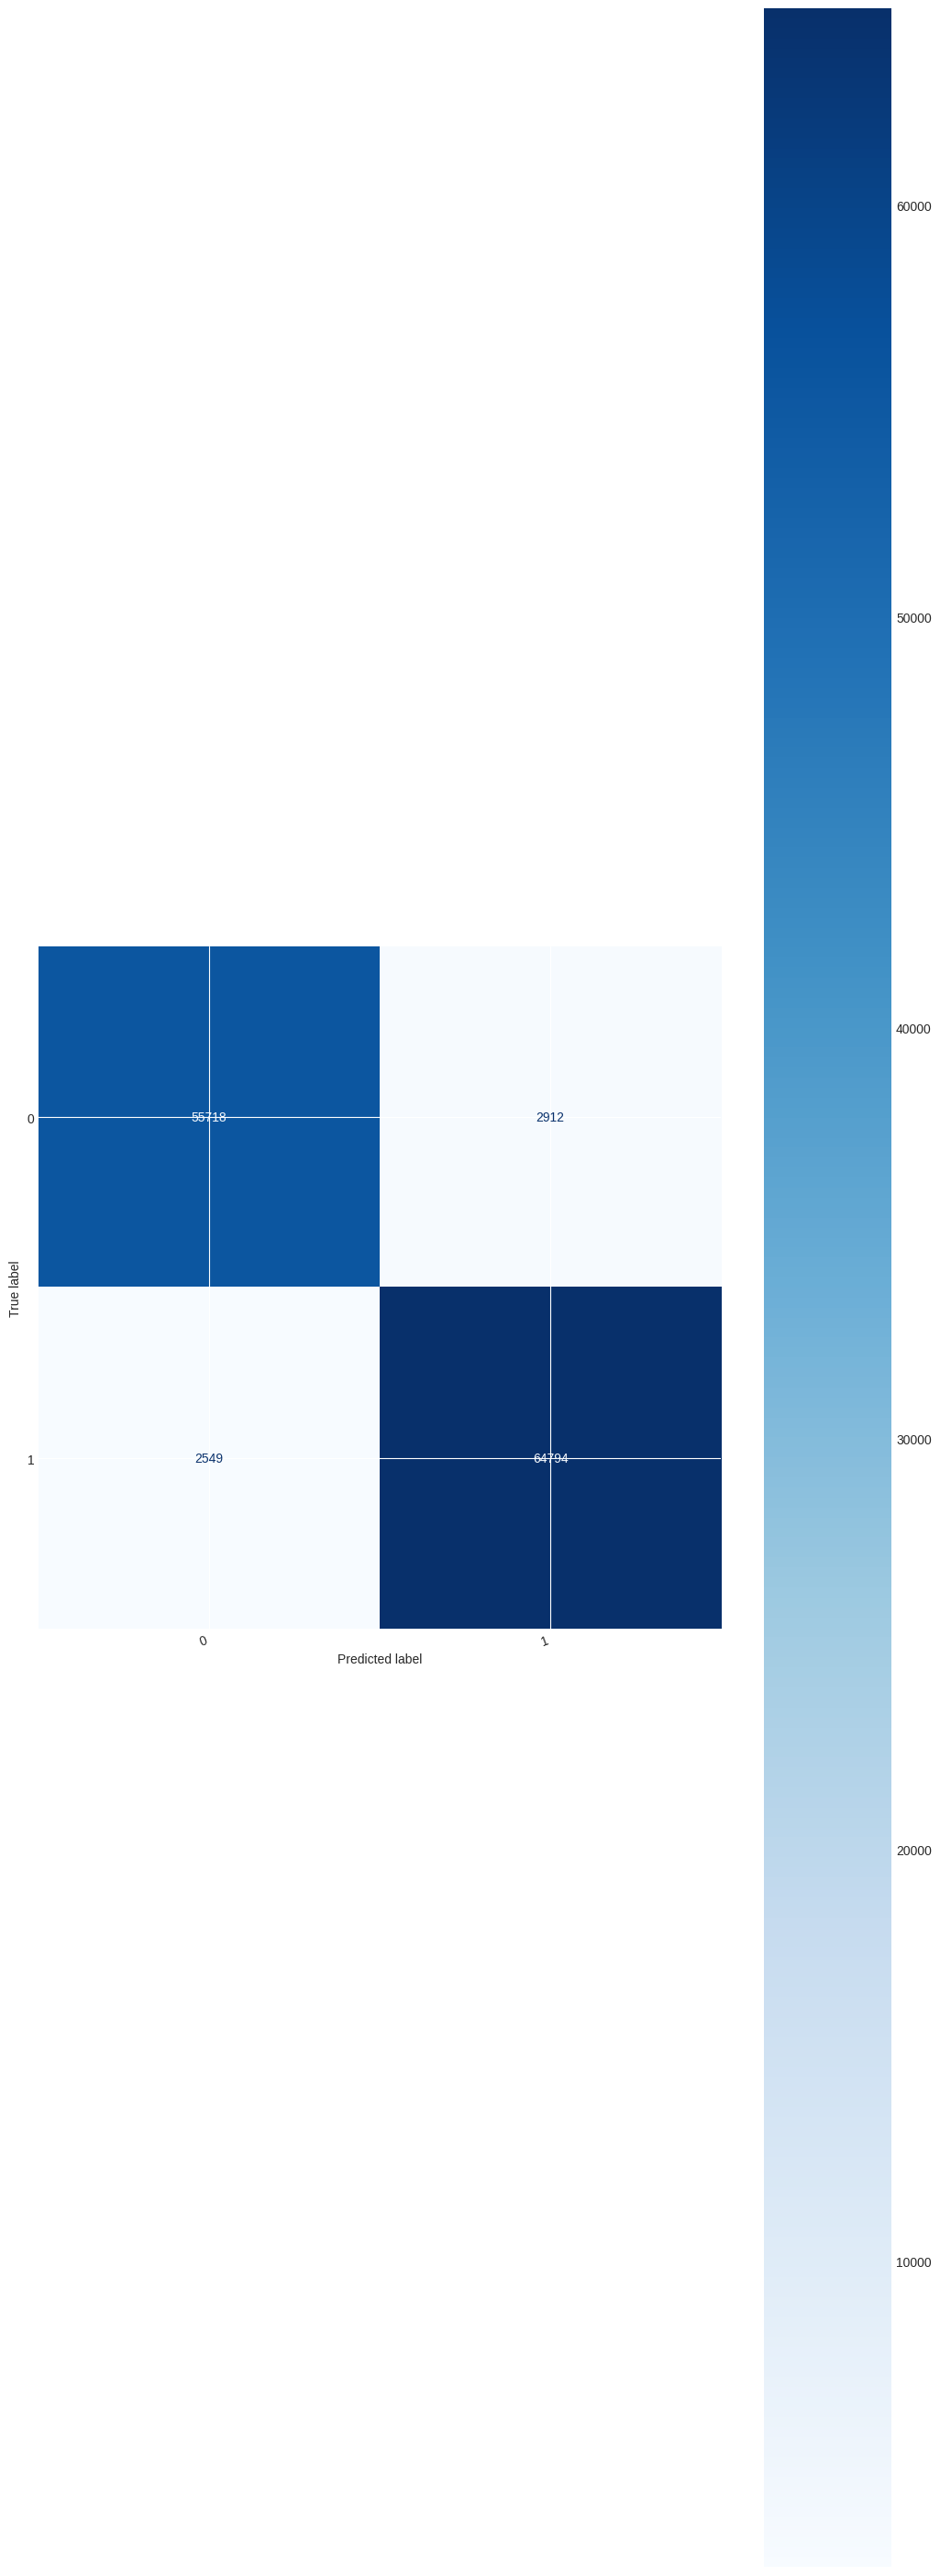

In [ ]:
# Testing
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_predictions(model, iterator, device):
    model.eval()
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            labels.append(y.cpu())
            probs.append(y_pred.cpu())

    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return labels, probs

def plot_confusion_matrix(labels, pred_labels, classes):
    fig, ax = plt.subplots(figsize=(12, 160))

    # Calculate confusion matrix
    cm = confusion_matrix(labels, pred_labels, labels=classes)

    # Use ConfusionMatrixDisplay for better styling
    cm_display = ConfusionMatrixDisplay(cm, display_labels=classes)

    # Plot the confusion matrix with styling
    cm_display.plot(values_format='d', cmap='Blues', ax=ax)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=20, ha='right')

    # Add a title
    # plt.title('Confusion Matrix', fontsize=16)

    # Show the plot
    plt.show()


# Load the best model
transfer_model.load_state_dict(torch.load('transfer_best_model.pt'))

# Evaluate the model on the test set
test_loss, test_acc = evaluate(transfer_model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss} | Test Accuracy: {test_acc}')

# Get predictions on the test set
labels, probs = get_predictions(transfer_model, test_iterator, device)
pred_labels = (probs[:, 0] > 0.6).int()

# Plot the confusion matrix
classes = [0, 1]  # Update with your actual class labels
plot_confusion_matrix(labels, pred_labels, classes)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# After the training loop and get_predictions function
# Get predictions on the test set
labels, probs = get_predictions(transfer_model, test_iterator, device)
pred_labels = (probs[:, 0] > 0.5).int()  # Convert probabilities to binary labels

# Calculate metrics
accuracy = accuracy_score(labels, pred_labels)
precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)
f1 = f1_score(labels, pred_labels)
roc_auc = roc_auc_score(labels, probs[:, 0])

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'AUC-ROC: {roc_auc}')


Accuracy: 0.9572130535908489
Precision: 0.9525618361652081
Recall: 0.9681778358552485
F1-Score: 0.9603063554017233
AUC-ROC: 0.9835624991083234


<ipython-input-70-1a95d6609103>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


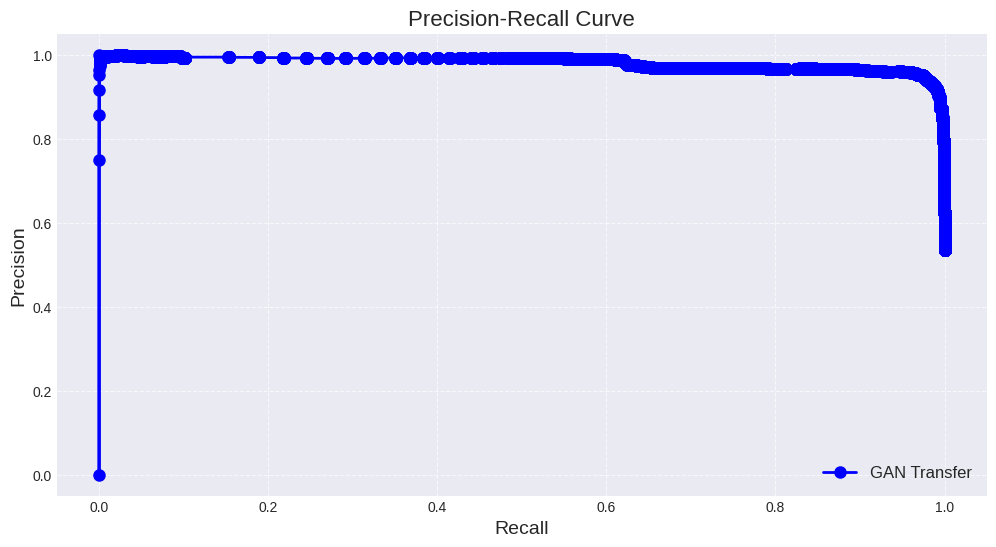

In [ ]:
# Calculate precision-recall curve
# Assuming 'labels' and 'probs' are defined
precision, recall, _ = precision_recall_curve(labels, probs[:, 0])

# Use the PrecisionRecallDisplay for better styling
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, estimator_name='GAN Transfer')

# Set plot style
plt.style.use('seaborn-darkgrid')

# Create a figure with adjusted size
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the Precision-Recall Curve
pr_display.plot(color='b', linestyle='-', linewidth=2, markersize=8, marker='o', label='GAN Transfer', ax=ax)

# Customize the plot
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


<ipython-input-76-b90d01b61782>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


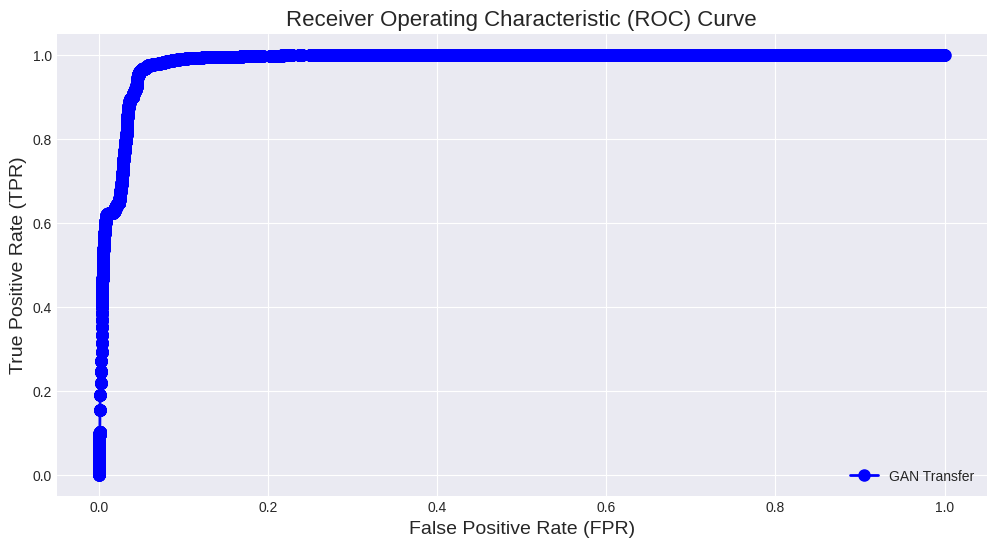

In [ ]:
# Assuming 'labels' and 'probs' are defined
fpr, tpr, _ = roc_curve(labels, probs[:, 0])

# Use the RocCurveDisplay for better styling
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name='GAN Transfer')

# Set plot style
plt.style.use('seaborn-darkgrid')

# Create a figure with adjusted size
fig, ax = plt.subplots(figsize=(12, 6))
roc_display.plot(color='b', linestyle='-', linewidth=2, markersize=8, marker='o', label='GAN Transfer', ax=ax)
# Plot the Receiver Operating Characteristic (ROC) Curve
# roc_display.plot(ax=ax)

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
# plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()